<a href="https://colab.research.google.com/github/yevonnaelandrew/galaxy-classification-ensemble/blob/main/All_Color_Space_ResNet50_Non_trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun  4 03:51:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   35C    P0    29W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [16]:
def train_model():
  data_dir = pathlib.Path('content/img_RGB')

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)
  x = tf.keras.applications.resnet50.preprocess_input(x)
  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

In [7]:
import time

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
1440/1440 [==============================] - 34s 19ms/step - loss: 0.6399 - accuracy: 0.7465 - val_loss: 0.4946 - val_accuracy: 0.7984
Epoch 2/100
1440/1440 [==============================] - 26s 18ms/step - loss: 0.4870 - accuracy: 0.7987 - val_loss: 0.4169 - val_accuracy: 0.8235
Epoch 3/100
1440/1440 [==============================] - 25s 17ms/step - loss: 0.4547 - accuracy: 0.8107 - val_loss: 0.4061 - val_accuracy: 0.8260
Epoch 4/100
1440/1440 [==============================] - 26s 18ms/step - loss: 0.4397 - accuracy: 0.8187 - val_loss: 0.3831 - val_accuracy: 0.8416
Epoch 5/100
1440/1440 [==============================] - 25s 17ms/step - loss: 0.4235 - accuracy: 0.8247 - val_loss: 0.3808 - val_accuracy: 0.8421
Epoch 6/100
1440/1440 [==============================] - 24s 17ms/step - loss: 0.4157 - accuracy: 0.8298 - val_loss:

1440/1440 [==============================] - 24s 17ms/step - loss: 0.3013 - accuracy: 0.8821 - val_loss: 0.3186 - val_accuracy: 0.8743
Epoch 56/100
1440/1440 [==============================] - 24s 16ms/step - loss: 0.3065 - accuracy: 0.8804 - val_loss: 0.2951 - val_accuracy: 0.8847
Epoch 57/100
1440/1440 [==============================] - 25s 17ms/step - loss: 0.3047 - accuracy: 0.8786 - val_loss: 0.3287 - val_accuracy: 0.8750
Epoch 58/100
1440/1440 [==============================] - 25s 17ms/step - loss: 0.2919 - accuracy: 0.8842 - val_loss: 0.3133 - val_accuracy: 0.8784
Epoch 59/100
1440/1440 [==============================] - 24s 16ms/step - loss: 0.2977 - accuracy: 0.8815 - val_loss: 0.2987 - val_accuracy: 0.8856
Epoch 60/100
1440/1440 [==============================] - 24s 16ms/step - loss: 0.2939 - accuracy: 0.8852 - val_loss: 0.3059 - val_accuracy: 0.8807
Epoch 61/100
1440/1440 [==============================] - 24s 16ms/step - loss: 0.3003 - accuracy: 0.8830 - val_loss: 0.3049 

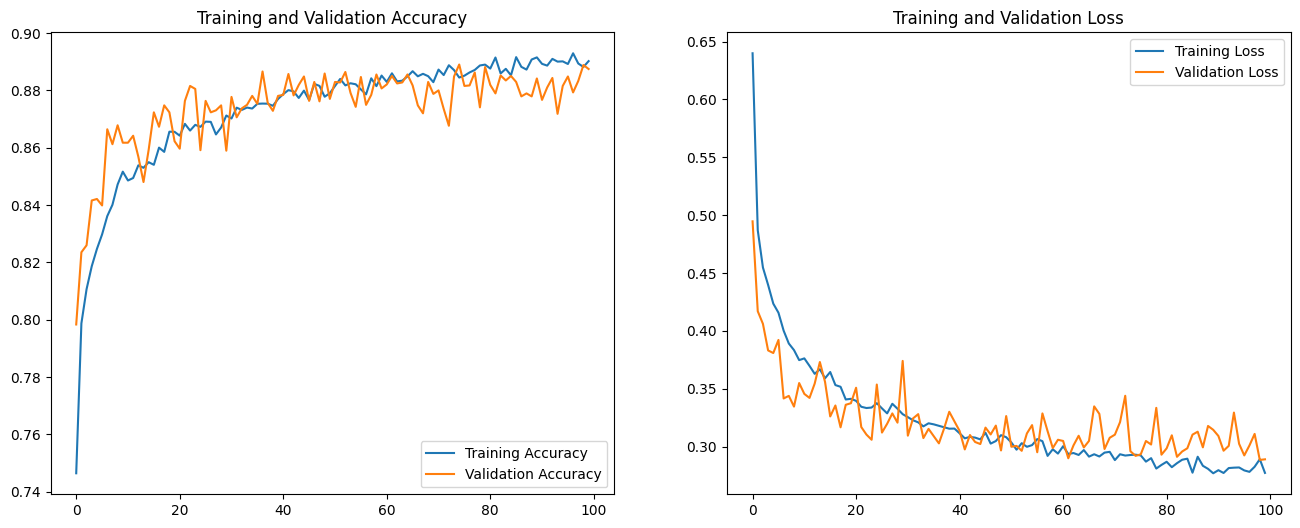

2677.8517603874207


In [8]:
start = time.time()
bs_16 = train_model()
end = time.time()
delta = end - start
print(delta)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
720/720 [==============================] - 22s 24ms/step - loss: 0.6521 - accuracy: 0.7447 - val_loss: 0.4538 - val_accuracy: 0.8090
Epoch 2/100
720/720 [==============================] - 17s 24ms/step - loss: 0.4919 - accuracy: 0.7912 - val_loss: 0.4652 - val_accuracy: 0.8095
Epoch 3/100
720/720 [==============================] - 16s 22ms/step - loss: 0.4633 - accuracy: 0.8049 - val_loss: 0.4432 - val_accuracy: 0.8064
Epoch 4/100
720/720 [==============================] - 16s 23ms/step - loss: 0.4380 - accuracy: 0.8154 - val_loss: 0.4075 - val_accuracy: 0.8364
Epoch 5/100
720/720 [==============================] - 16s 22ms/step - loss: 0.4142 - accuracy: 0.8291 - val_loss: 0.3765 - val_accuracy: 0.8473
Epoch 6/100
720/720 [==============================] - 16s 23ms/step - loss: 0.4052 - accuracy: 0.8346 - val_loss: 0.3737 - va

720/720 [==============================] - 16s 22ms/step - loss: 0.2954 - accuracy: 0.8830 - val_loss: 0.3310 - val_accuracy: 0.8727
Epoch 57/100
720/720 [==============================] - 16s 23ms/step - loss: 0.2917 - accuracy: 0.8842 - val_loss: 0.3030 - val_accuracy: 0.8803
Epoch 58/100
720/720 [==============================] - 16s 22ms/step - loss: 0.2919 - accuracy: 0.8835 - val_loss: 0.2979 - val_accuracy: 0.8828
Epoch 59/100
720/720 [==============================] - 16s 22ms/step - loss: 0.2898 - accuracy: 0.8850 - val_loss: 0.3061 - val_accuracy: 0.8835
Epoch 60/100
720/720 [==============================] - 16s 22ms/step - loss: 0.2879 - accuracy: 0.8871 - val_loss: 0.2987 - val_accuracy: 0.8878
Epoch 61/100
720/720 [==============================] - 16s 22ms/step - loss: 0.2833 - accuracy: 0.8859 - val_loss: 0.3069 - val_accuracy: 0.8826
Epoch 62/100
720/720 [==============================] - 16s 22ms/step - loss: 0.2934 - accuracy: 0.8833 - val_loss: 0.3015 - val_accuracy

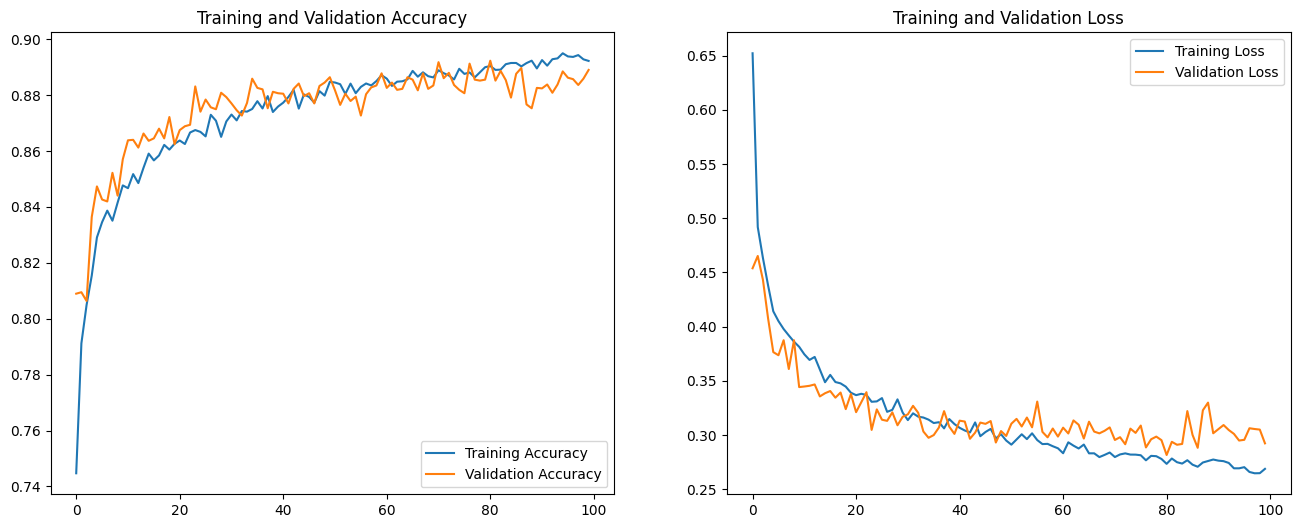

1690.756758928299


In [15]:
start = time.time()
bs_32 = train_model()
end = time.time()
delta = end - start
print(delta)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 18s 38ms/step - loss: 0.6831 - accuracy: 0.7420 - val_loss: 0.5307 - val_accuracy: 0.7647
Epoch 2/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4929 - accuracy: 0.7922 - val_loss: 0.4075 - val_accuracy: 0.8270
Epoch 3/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4634 - accuracy: 0.8047 - val_loss: 0.4056 - val_accuracy: 0.8284
Epoch 4/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4420 - accuracy: 0.8145 - val_loss: 0.3843 - val_accuracy: 0.8364
Epoch 5/100
360/360 [==============================] - 12s 34ms/step - loss: 0.4266 - accuracy: 0.8234 - val_loss: 0.3853 - val_accuracy: 0.8421
Epoch 6/100
360/360 [==============================] - 12s 35ms/step - loss: 0.4078 - accuracy: 0.8327 - val_loss: 0.3860 - va

360/360 [==============================] - 12s 34ms/step - loss: 0.2896 - accuracy: 0.8831 - val_loss: 0.3165 - val_accuracy: 0.8755
Epoch 57/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2829 - accuracy: 0.8871 - val_loss: 0.3022 - val_accuracy: 0.8836
Epoch 58/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2871 - accuracy: 0.8860 - val_loss: 0.3093 - val_accuracy: 0.8779
Epoch 59/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2905 - accuracy: 0.8812 - val_loss: 0.2959 - val_accuracy: 0.8859
Epoch 60/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2913 - accuracy: 0.8832 - val_loss: 0.3037 - val_accuracy: 0.8793
Epoch 61/100
360/360 [==============================] - 12s 33ms/step - loss: 0.2829 - accuracy: 0.8841 - val_loss: 0.3076 - val_accuracy: 0.8784
Epoch 62/100
360/360 [==============================] - 12s 34ms/step - loss: 0.2861 - accuracy: 0.8863 - val_loss: 0.2990 - val_accuracy

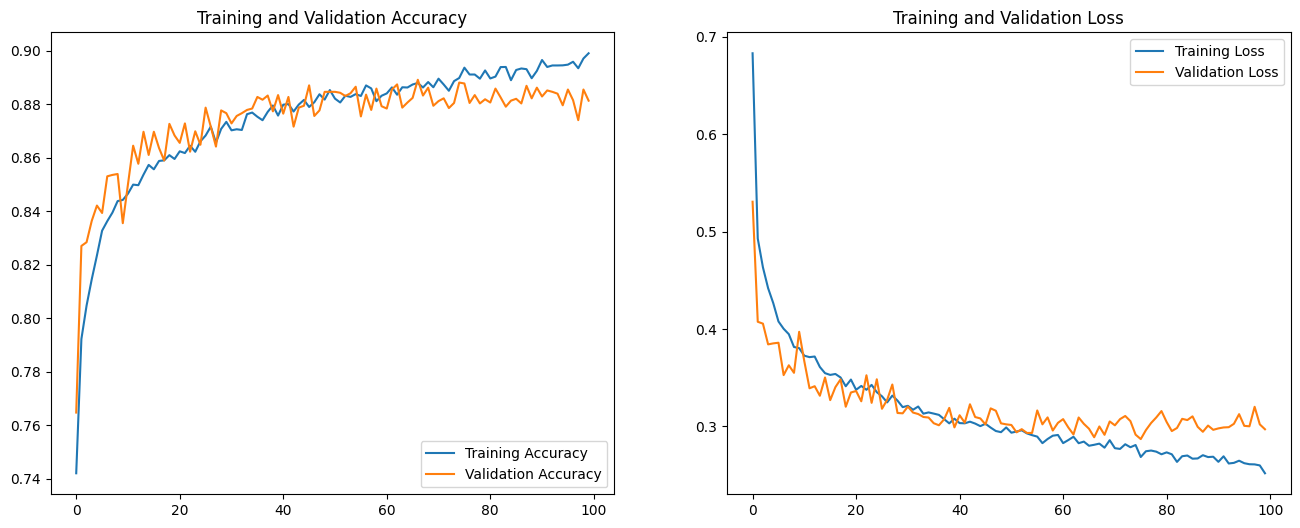

1309.8209433555603


In [17]:
start = time.time()
bs_64 = train_model()
end = time.time()
delta = end - start
print(delta)

In [18]:
# !mkdir batch_size
# pd.DataFrame(bs_16).to_csv("batch_size/bs_16.csv", index=False)
# pd.DataFrame(bs_32).to_csv("batch_size/bs_32.csv", index=False)
# pd.DataFrame(bs_64).to_csv("batch_size/bs_64.csv", index=False)